# Objective

To build a Deep Learning model which can identify if the person is wearing a mask or not.

**Benefits associated** - In the time of Global Pandamic it's necessay to follow the guidelines delivered by WHO for bona fide of humanity. Out of which two major ones are:-
- *Social distancing*, also called “*physical distancing*,” means keeping a safe space between yourself and other people who are not from your household.
- *Wearing Mask*  while in public, Masks are a simple barrier to help prevent your respiratory droplets from reaching others. Studies show that masks reduce the spray of droplets when worn over the nose and mouth.

Our, Algorithms can be installed in Resturants, Shopping Malls, Parking, Offices where entry will be permitted to person wearing mask in an automated way.

## About Dataset
The dataset consisted of 12k images, ~6K face images with masks and ~6k without masks. The original dataset is prepared by Ashish Jangra and available at [Kaggle](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)

Dataset is Divided into 3 sections - Train, Test, Validation

Dataset has two attributes - **WithoutMask** and **WithMask**

Dataset is already agumentated and sufficient enoungh for prediction without underfitting.
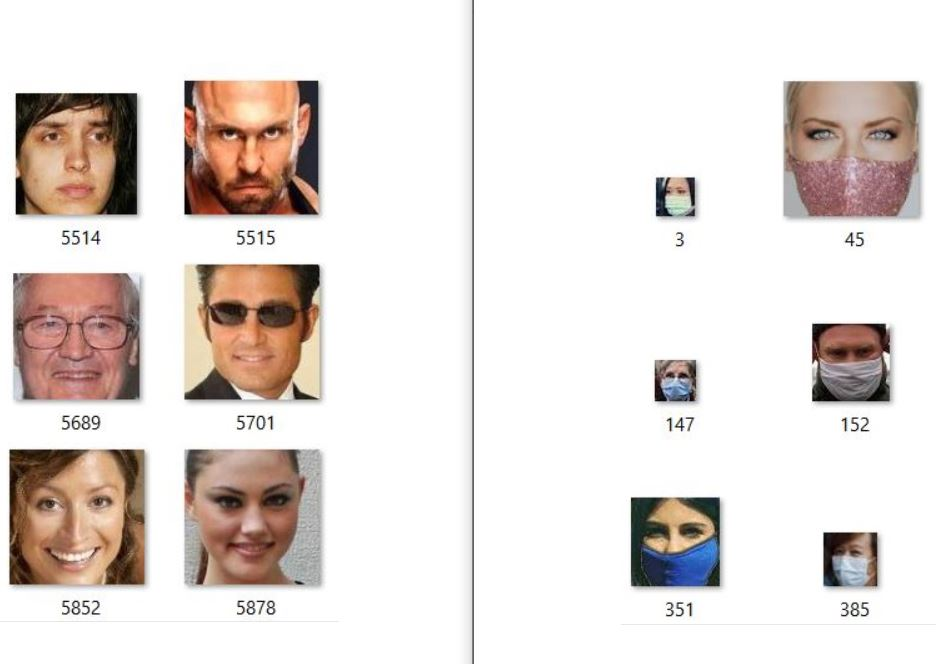

In [3]:
import os
os.chdir('D:\PROJECT\Face Mask Detection')

In [ ]:
for dirname, _, filenames in os.walk('.\Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [16]:
data_dir=os.listdir('Dataset')
data_dir

['Test', 'Train', 'Validation']

In [4]:
print("The number of images With facemask in training dataset:",len(os.listdir('Dataset\Train\WithMask')))
print("The number of images With-Out facemask in training dataset:",len(os.listdir('Dataset\Train\WithoutMask')))

The number of images With facemask in training dataset: 5000
The number of images With-Out facemask in training dataset: 5000


### Data Preprocessing


In [5]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

In data preprocessing - we will store coresponding image after

- 1. Reading image with Open CV
- 2. Converting into Grayscale
- 3. Resizing image for consistency
- 4. Normalization
- 5. Reshaping 
- 6. Converting Label into Categorical Variable and storing into list with same index as image array.

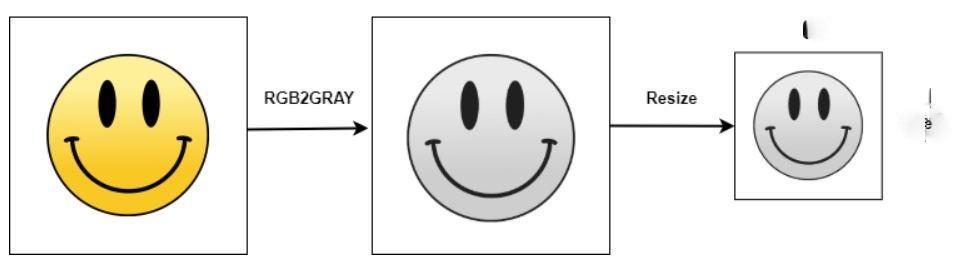

In [25]:
img_size=112

images_dict={}
labels_dict={}

for selector in  data_dir:
    data_path='Dataset/'+selector
    images_dict["images_{0}".format(selector)]=[]
    labels_dict["labels_{0}".format(selector)]=[]
    for category in os.listdir(data_path):
        path=os.path.join(data_path,category)
        for img in os.listdir(path):
            img_path=os.path.join(path,img)
            img=cv2.imread(img_path)
            
            try:
                #Converting into GrayScale
                grayscale_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                
                #resizing image for consistency
                resized_img=cv2.resize(grayscale_img,(img_size,img_size))
                images_dict["images_{0}".format(selector)].append(resized_img)
                labels_dict["labels_{0}".format(selector)].append(category)
            except Exception as e:
                print('Exception:-',e)

In [74]:
labels_dict.keys()

dict_keys(['labels_Test', 'labels_Train', 'labels_Validation'])

In [75]:
images_dict.keys()

dict_keys(['images_Test', 'images_Train', 'images_Validation'])

In [76]:
len(images_dict['images_Train'])

10000

In [77]:
#Scaling data without changing prominent data
train_data=np.array(images_dict['images_Train'])/255.0

#Reshaping for feeding into Convolutional Neural Network
train_data=np.reshape(train_data,(train_data.shape[0],img_size,img_size,1))

In [78]:
test_data=np.array(images_dict['images_Test'])/255.0
test_data=np.reshape(test_data,(test_data.shape[0],img_size,img_size,1))

In [79]:
val_data=np.array(images_dict['images_Validation'])/255.0
val_data=np.reshape(val_data,(val_data.shape[0],img_size,img_size,1))

In [80]:
train_data.shape

(10000, 112, 112, 1)

In [81]:
#Performing one hot encoding on the labels since the labels are in textual form

lb=LabelBinarizer()

for x in labels_dict.keys():
    labels_dict[x]=lb.fit_transform(labels_dict[x])

In [82]:
train_label=np.array(to_categorical(labels_dict['labels_Train']))

In [83]:
test_label=np.array(to_categorical(labels_dict['labels_Test']))

In [84]:
val_label=np.array(to_categorical(labels_dict['labels_Validation']))

In [85]:
#Saving array for further use
np.save('train_data',train_data)
np.save('train_label',train_label)

In [86]:
np.save('test_data',test_data)
np.save('test_label',test_label)

In [87]:
np.save('val_data',val_data)
np.save('val_label',val_label)

# Model

In [6]:
# Importing Necessay Library
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D

In [48]:

# Model Parameters

int_class=2
batch_size=32 #how many images pass throung CNN before its internal weight updation

#Model API
model=Sequential()

#LAYERS

#first

model.add(Conv2D(64,(3,3),input_shape=(img_size,img_size,1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


#Flatten and Dropout
model.add(Flatten())
model.add(Dropout(0.2))

#Dense and Classifier
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dense(int_class,activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)            

In [90]:
from keras.optimizers import Adam, RMSprop

epochs=50

model.compile(loss='binary_crossentropy',
             optimizer=Adam(lr=0.001),
             metrics=['accuracy'])


steps_per_epoch = train_data.shape[0] // batch_size
final=model.fit(train_data,train_label,
               epochs = epochs,
               validation_data = (val_data,val_label),
                batch_size=batch_size,
               steps_per_epoch = steps_per_epoch)

Epoch 1/50
312/312 [==============================] - 344s 1s/step - loss: 0.2273 - accuracy: 0.9044 - val_loss: 0.1691 - val_accuracy: 0.9325
Epoch 2/50
312/312 [==============================] - 316s 1s/step - loss: 0.0860 - accuracy: 0.9702 - val_loss: 0.1135 - val_accuracy: 0.9613
Epoch 3/50
312/312 [==============================] - 312s 1s/step - loss: 0.0593 - accuracy: 0.9793 - val_loss: 0.0603 - val_accuracy: 0.9762
Epoch 4/50
312/312 [==============================] - 312s 999ms/step - loss: 0.0434 - accuracy: 0.9841 - val_loss: 0.0529 - val_accuracy: 0.9812
Epoch 5/50
312/312 [==============================] - 1468s 5s/step - loss: 0.0358 - accuracy: 0.9884 - val_loss: 0.0529 - val_accuracy: 0.9812
Epoch 6/50
312/312 [==============================] - 313s 1s/step - loss: 0.0309 - accuracy: 0.9893 - val_loss: 0.0676 - val_accuracy: 0.9750
Epoch 7/50
312/312 [==============================] - 313s 1s/step - loss: 0.0178 - accuracy: 0.9936 - val_loss: 0.0884 - val_accuracy: 0.

In [91]:
#Saving Model for Further use
model.save('face_mask_detection.h5')

## Model Explanation

- Model used here is CNN with maxpooling, Sigmoid activation is since output is Binary (i.e. 0,1) for Output class greater than 2 Softmax function is preffered.
- We can use either VVG19, InceptionV3, DenseNet for better result and less computation.
- My model took approx 3 hours to train.. eventually led to overfitting.
- When data is trained for images which were clear, but using Laptop webcame model tends to confuse


### Understanding Haarcascade Face Detector

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [18]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [17]:
import matplotlib.pyplot as plt

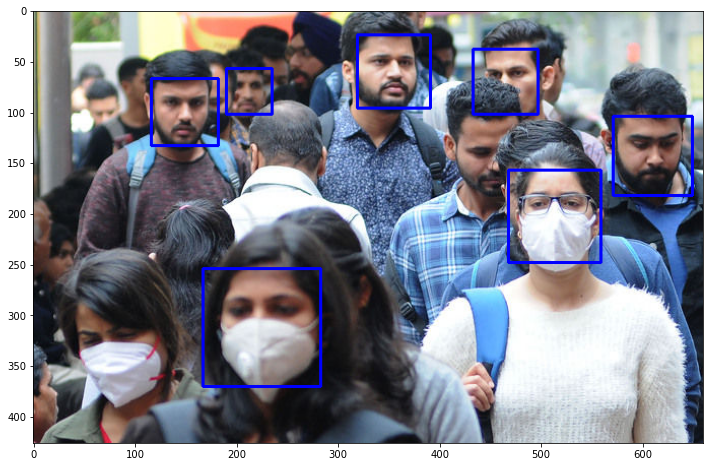

In [44]:
img = cv2.imread('MASK.jpg')
img2 = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

#returns a list of (x,y,w,h) tuples
faces = face_model.detectMultiScale(img2,scaleFactor=1.2, minNeighbors=5) 

#plotting
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
plt.figure(figsize=(12,12))
plt.imshow(img)

## Live Video Capture

In [8]:
#Import necessary Lib

from keras.models import load_model
import tkinter


In [9]:
#Loding model
model=load_model('face_mask_detection.h5')
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [10]:
#Video Source
vid=cv2.VideoCapture(0)

text_dict={0:'With Mask',1:'Without Mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [12]:
while (True):
    ret,img=vid.read()
    gry_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces= face_model.detectMultiScale(gry_img,scaleFactor=1.3, minNeighbors=4)
    
    for (x,y,w,h) in faces:
        
        face_img=gry_img[y:y+w,x:x+w]
        resized_img=cv2.resize(face_img,(112,112))
        normalized_img=resized_img/255.0
        reshaped_img=np.reshape(normalized_img,(1,112,112,1))
        result=model.predict(reshaped_img)
        
        label=np.argmax(result,axis=1)[0]
        
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img,text_dict[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,0),2)
        
    cv2.imshow('Live Video',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
cv2.destroyAllWindows()

## For Photo Demonstration

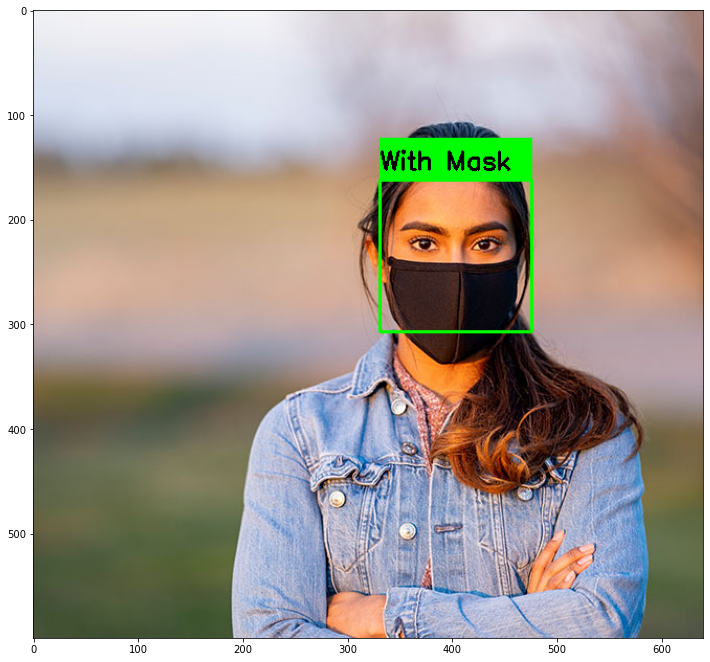

In [25]:
img = cv2.imread('test.jpg')
gry_img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#returns a list of (x,y,w,h) tuples
faces = face_model.detectMultiScale(gry_img,scaleFactor=1.3, minNeighbors=4) 

#plotting

for (x,y,w,h) in faces:

    face_img=gry_img[y:y+w,x:x+w]
    resized_img=cv2.resize(face_img,(112,112))
    normalized_img=resized_img/255.0
    reshaped_img=np.reshape(normalized_img,(1,112,112,1))
    result=model.predict(reshaped_img)

    label=np.argmax(result,axis=1)[0]

    cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(img,text_dict[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,0),2)
plt.figure(figsize=(12,12))
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)


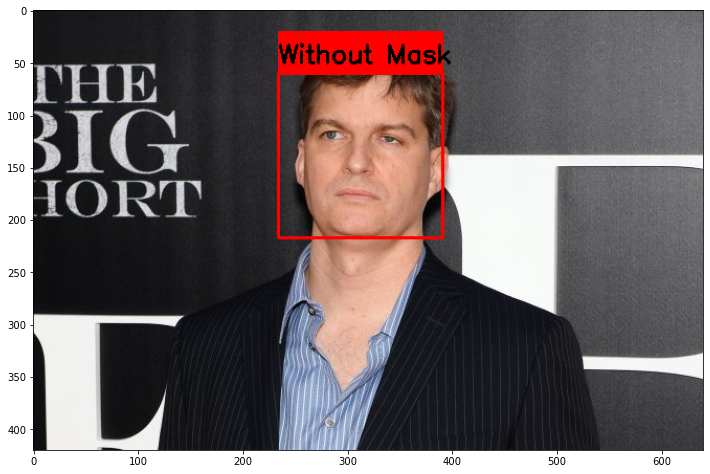

In [45]:
img = cv2.imread('test2.jpg')
gry_img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#returns a list of (x,y,w,h) tuples
faces = face_model.detectMultiScale(gry_img,scaleFactor=1.6, minNeighbors=4) 

#plotting

for (x,y,w,h) in faces:

    face_img=gry_img[y:y+w,x:x+w]
    resized_img=cv2.resize(face_img,(112,112))
    normalized_img=resized_img/255.0
    reshaped_img=np.reshape(normalized_img,(1,112,112,1))
    result=model.predict(reshaped_img)

    label=np.argmax(result,axis=1)[0]

    cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(img,text_dict[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,0),2)
plt.figure(figsize=(12,12))
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)


## Summary ,Key Findings and Insights

- Our Model is able to make prediction better when image is clear (Poor result on blur images) 
- We have to tune **scaleFactor** in Haarcascade face detector as sometimes anomly is detected.
- We can lower number of layers as it is causing overfitting of data

## Suggestions for next steps

- We can use Pre-trained CNN model such as VGG19 , DenseNet etc for better classification
- We can use DATA AGUMENTATION for generating more data which can handle face at different degree's
- Model can be installed in Mall Entry, where door opens onlhy when person is wearing mask.
- We can further develop our code for handling multiple person at a time.
- we can also set SOCIAL DISTANCING norm and alert is send when someone violate using Ecudilean distance for multiple faces.